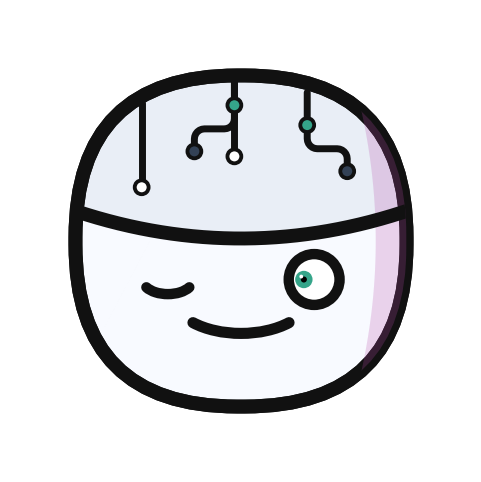

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from draw_face_helpers import (
    draw_face_patch,
    draw_face_brain,
    add_circle_lens_shadow,
    add_one_brain_circuit_from_brain_top,
    add_rect_bent_double_node_from_brain_top,
    draw_eyes,
    add_smile,
    background_circle,
)

# ============================
# Global style (Smart-Tinmen)
# ============================

# Geometry / stroke
FIGSIZE = (6, 6)
DPI = 100
LW_OUTLINE = 10

FACE_SIZE = 0.86
FACE_ROUND_TOP = 0.42
FACE_ROUND_BOT = 0.42

# Fills (robot screen vibe)
BRAIN_COLOR = "#E9EEF6"   # cool light slate
FACE_COLOR  = "#F8FAFF"   # slightly blue-white
LINE_COLOR  = "#111111"   # near-black

# Lens shading (clean violet/rose)
LENS_BRAIN = "#6D28D9"
LENS_FACE  = "#FB7185"
LENS_ALPHA = 0.12

# Circuits
WIRE_COLOR = "#111111"
NODE_LED   = "#35A58A"    # teal/cyan LED
NODE_METAL = "#334155"    # slate “metal”
NODE_EDGE  = "#111111"
BACKGROUND_COLOR   = "#35A58A"

# Eyes (slightly more robotic camera vibe)
EYE_IRIS   = "#35A58A"
EYE_PUPIL_RATIO = 0.35
EYE_SPEC_RATIO  = 0.22
EYE_GAZE_STRENGTH = 0.45

# Expression tweak (tiny robot)
EYES_CY = 0.42
SMILE_Y = -0.14
SMILE_W = 0.36
SMILE_H = 0.20


def demo():
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_aspect("equal")
    ax.axis("off")
    fig.canvas.draw()
    # Face outline
    face_outline = draw_face_patch(
        width=FACE_SIZE,
        height=FACE_SIZE,
        angle_top_to_bottom=0,
        rounding_top=FACE_ROUND_TOP,
        rounding_bottom=FACE_ROUND_BOT,
        cx=0.5, cy=0.5,
        facecolor="none",
        edgecolor=LINE_COLOR,
        lw=LW_OUTLINE,
        zorder=20,
    )
    
    # oval look
    #face_outline = draw_face_patch(width=0.86, height=0.9, shape="oval")

    ax.add_patch(face_outline)

    # Brain/face split fills
    brain_fill, face_fill, sep_line = draw_face_brain(
        ax, face_outline,
        cx=0.5, cy=0.5,
        y_pos_px=30,
        curvature_px=-55,
        curve_dir="down", # up or down
        fill_pad_px=0,
        sep_n=700,
        boundary_interp=220,
        lw=LW_OUTLINE,
        brain_color=BRAIN_COLOR,
        face_color=FACE_COLOR,
        line_color=LINE_COLOR,
    )

    # Lens shadow
    add_circle_lens_shadow(
        ax,
        face_outline=face_outline,
        circle_center=(0.5 - 1.2, 0.5),
        radius=1.55,
        brain_shadow_color=LENS_BRAIN,
        face_shadow_color=LENS_FACE,
        alpha=LENS_ALPHA,
        region="outside",
        prefer="right",
        zorder=28,
    )

    # Two straight hanging circuits
    add_one_brain_circuit_from_brain_top(
        ax, face_outline,
        center_shift=-0.02,
        length_px=80,
        node_r=0.018,
        node_facecolor="#FFFFFF",
        node_edgecolor=NODE_EDGE,
        wire_lw=LW_OUTLINE * 0.50,
        wire_color=WIRE_COLOR,
        zorder=26,
    )

    add_one_brain_circuit_from_brain_top(
        ax, face_outline,
        center_shift=-0.30,
        length_px=80,
        node_r=0.018,
        node_facecolor="#FFFFFF",
        node_edgecolor=NODE_EDGE,
        wire_lw=LW_OUTLINE * 0.50,
        wire_color=WIRE_COLOR,
        zorder=26,
    )

    # Left bent circuit (mirrored)
    add_rect_bent_double_node_from_brain_top(
        ax, face_outline,
        center_shift=-0.02,
        length_px=75,
        bend_px=40,
        bend_at=0.7,
        bend_dir=-1,
        corner_px=12,
        corner_n=7,
        node1_on="vertical1",
        node1_u=0.58,
        node_facecolor1=NODE_LED,
        node_facecolor2=NODE_METAL,
        node_edgecolor=NODE_EDGE,
        node_r=0.018,
        wire_color=WIRE_COLOR,
        wire_lw=LW_OUTLINE * 0.50,
        zorder=26,
    )

    # Right bent circuit
    add_rect_bent_double_node_from_brain_top(
        ax, face_outline,
        center_shift=0.20,
        length_px=75,
        bend_px=40,
        bend_at=0.7,
        bend_dir=+1,
        corner_px=12,
        corner_n=7,
        node1_on="vertical1",
        node1_u=0.58,
        node_facecolor1=NODE_LED,
        node_facecolor2=NODE_METAL,
        node_edgecolor=NODE_EDGE,
        node_r=0.018,
        wire_color=WIRE_COLOR,
        wire_lw=LW_OUTLINE * 0.50,
        zorder=26,
    )

    # Eyes (gaze demo: cross-eyed cute robot)
    draw_eyes(
        ax, face_outline,
        cx=0.5, cy=EYES_CY,
        open_left=False, open_right=True,
        eye_dx=0.19, eye_dy=-0.02,
        r=0.066,
        wink_lw=LW_OUTLINE * 0.75,
        outline_color=LINE_COLOR,
        iris_color_left=EYE_IRIS,
        iris_color_right=EYE_IRIS,
        ring_ratio=0.10,
        iris_ratio=0.38,
        pupil_ratio=EYE_PUPIL_RATIO,
        spec_ratio=EYE_SPEC_RATIO,
        spec_offset=(0.30, 0.34),
        iris_offset_y=0.0,
        gaze_left=(1.0, 0.0),
        gaze_right=(-1.0, 0.0),
        gaze_strength=EYE_GAZE_STRENGTH,
        aa_shrink=0.995,
    )

    # Smile
    add_smile(
        ax, face_outline,
        cx=0.5, cy=0.5,
        y=SMILE_Y,
        w=SMILE_W, h=SMILE_H,
        theta1=210, theta2=330,
        lw=LW_OUTLINE * 0.80,
        color=LINE_COLOR,
    )

    ax.add_patch(face_outline)

    background_circle(
        ax,
        center=(0.5, 0.5),
        radius=0.58,
        color=BACKGROUND_COLOR,
        alpha=0.0,
        edgecolor="black",
        lw=5,
        zorder=0
    )


    
    plt.show()
    return face_outline

if __name__ == "__main__":
    face_outline =demo()
